# Custom Transformer

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn import set_config; set_config(display="diagram")
import itertools

## Loading the dataset

- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.
- The target is the number of days between the order and the delivery.

In [2]:
data = pd.read_csv("../data/workflow/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


In [3]:
data.describe()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8328.359000,52.580000,39.418000,30.876000,19.913000
std,5743.795899,12.026064,21.715728,12.298857,13.571058
min,100.000000,20.000000,5.000000,11.000000,3.000000
25%,1887.500000,45.000000,15.000000,22.000000,12.000000
50%,8683.000000,53.000000,51.000000,31.000000,18.000000
75%,12275.000000,57.000000,56.000000,36.000000,25.000000
max,30000.000000,102.000000,93.000000,118.000000,194.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_state       1000 non-null   object
 1   seller_state         1000 non-null   object
 2   product_weight_g     1000 non-null   int64 
 3   product_length_cm    1000 non-null   int64 
 4   product_height_cm    1000 non-null   int64 
 5   product_width_cm     1000 non-null   int64 
 6   days_until_delivery  1000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 54.8+ KB


<Axes: xlabel='days_until_delivery', ylabel='Count'>

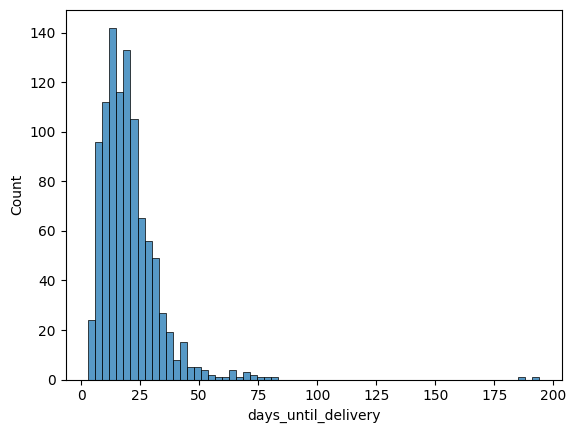

In [5]:
# Check the target
sns.histplot(data.days_until_delivery)

## (1) Pipeline

#### Preprocessing Solution 1: Function Transformer

In [14]:
X = data.drop(columns=['days_until_delivery'])
y = data.days_until_delivery

In [15]:
# Feature Engineering
volume_computer = Pipeline([
    ('compute_volume', FunctionTransformer(lambda data: pd.DataFrame(
        data["product_length_cm"] * data["product_height_cm"] * data["product_width_cm"]
    ))),
    ('scale_volume', MinMaxScaler())
])

# Preprocessor
preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), make_column_selector(dtype_exclude=['object'])),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'),
     make_column_selector(dtype_include=['object'])),
    ('volume_computer', volume_computer, ['product_length_cm','product_height_cm','product_width_cm'])
])

preprocessor

,transformers,"[('num_scaler', ...), ('cat_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [16]:
pd.DataFrame(preprocessor.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
1,0.020067,0.548780,0.147727,0.158879,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125218
2,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
3,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
4,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177


#### Preprocessing Solution 2: Custom transformer class (overkill)

In [17]:
# Create a class
class ColumnMultiplier(TransformerMixin, BaseEstimator):
    # TransformerMixin generates a fit_transform method from fit and transform
    # BaseEstimator generates get_params and set_params methods

    # Create parameters "column_1", "column_2", "column_3" to choose which columns of dataframe to multiply
    def __init__(self, column_1, column_2, column_3):
        self.column_1 = column_1
        self.column_2 = column_2
        self.column_3 = column_3
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Multiplication
        multiplied_features = X[self.column_1] * X[self.column_2] * X[self.column_3]

        # Return result as dataframe (for integration into ColumnTransformer)
        return pd.DataFrame(multiplied_features, columns=['volume'])

In [18]:
# Plug custom transformer into a feature engineering ColumnTransformer
# Select and preserve the original features
feature_engineering = ColumnTransformer([
    ( # ColumnMultiplier BEGIN 
        'column_multiplier', ColumnMultiplier(
            column_1="product_length_cm",
            column_2="product_height_cm",
            column_3="product_width_cm"
        ),
        ['product_length_cm', 'product_height_cm', "product_width_cm"]
    ), # ColumnMultiplier END
    ( # FunctionTransformer BEGIN
        'select_original_features', FunctionTransformer(lambda x: x),
        ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']
    ) # FunctionTransformer END
])

# Chain the feature engineering transformer with a scaler
numerical_pipe = Pipeline([
    ('engineering', feature_engineering),
    ('scaling', MinMaxScaler())
])

# Create a final preprocessing pipeline that combines the above pipeline with a One hot encoder for categorical features
final_preprocessor3 = ColumnTransformer([
    ('categorical_preprocessing', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary'),
     make_column_selector(dtype_include="object")),
    ('numerical_preprocessing', numerical_pipe, make_column_selector(dtype_include="int64"))
])

final_preprocessor3

,transformers,"[('categorical_preprocessing', ...), ('numerical_preprocessing', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,'if_binary'
,sparse_output,False


In [19]:
pd.DataFrame(final_preprocessor3.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.079177,0.402439,0.056818,0.271028,0.057692
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.125218,0.548780,0.147727,0.158879,0.020067
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.079177,0.402439,0.056818,0.271028,0.057692
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.079177,0.402439,0.056818,0.271028,0.057692
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.079177,0.402439,0.056818,0.271028,0.057692


In [20]:
final_preprocessor3.fit_transform(X).shape

(1000, 31)

In [21]:
preprocessor.fit_transform(X).shape

(1000, 31)

### Full pipe

In [22]:
# Chain the final_preprocessor pipeline with a linear regression model

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('linear_regression', Ridge())
])

pipe

,steps,"[('preprocessing', ...), ('linear_regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaler', ...), ('cat_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## (2) Train and Predict

In [31]:
cv_results = cross_val_score(pipe, X, y, cv=10, scoring='r2').mean()
cv_results

C:\Users\luan.barbosa\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\luan.barbosa\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\luan.barbosa\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


np.float64(0.15838731743600082)

In [ ]:
# Fit the final pipe to the data
pipe.fit(X, y)

,steps,"[('preprocessing', ...), ('linear_regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaler', ...), ('cat_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
# Predict on new data
new_data = pd.read_csv("../data/workflow/custom_transformer_new_order.csv")
new_data

prediction = pipe.predict(new_data)
prediction

array([20.65994518])

#### Solution Bonus: get feature names

In [36]:
pipe

,steps,"[('preprocessing', ...), ('linear_regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaler', ...), ('cat_encoder', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
pd.DataFrame(data=pipe['preprocessing'].fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
1,0.020067,0.548780,0.147727,0.158879,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125218
2,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
3,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
4,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177


In [39]:
set_config(display='text')
pipe['preprocessing'].transformers_

[('num_scaler',
  MinMaxScaler(),
  ['product_weight_g',
   'product_length_cm',
   'product_height_cm',
   'product_width_cm']),
 ('cat_encoder',
  OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False),
  ['customer_state', 'seller_state']),
 ('volume_computer',
  Pipeline(steps=[('compute_volume',
                   FunctionTransformer(func=<function <lambda> at 0x000001BFAF63CB80>)),
                  ('scale_volume', MinMaxScaler())]),
  ['product_length_cm', 'product_height_cm', 'product_width_cm'])]

In [40]:
col_num = pipe['preprocessing'].transformers_[0][2]
col_num

['product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm']

In [41]:
pipe['preprocessing'].transformers_[1][1].get_feature_names_out()

array(['customer_state_AL', 'customer_state_AM', 'customer_state_AP',
       'customer_state_BA', 'customer_state_CE', 'customer_state_DF',
       'customer_state_ES', 'customer_state_GO', 'customer_state_MA',
       'customer_state_MG', 'customer_state_MS', 'customer_state_MT',
       'customer_state_PA', 'customer_state_PB', 'customer_state_PE',
       'customer_state_PI', 'customer_state_PR', 'customer_state_RJ',
       'customer_state_RN', 'customer_state_RO', 'customer_state_RS',
       'customer_state_SC', 'customer_state_SE', 'customer_state_SP',
       'customer_state_TO', 'seller_state_SP'], dtype=object)

In [42]:
col_cat = list(pipe['preprocessing'].transformers_[1][1].get_feature_names_out())

In [43]:
pipe['preprocessing'].transformers_[2]
col_volume = ['volume']

In [45]:
col_preproc = list(itertools.chain(col_num, col_cat, col_volume))

In [46]:
len(col_preproc)

31

In [47]:
pd.DataFrame(data=pipe['preprocessing'].fit_transform(X), columns=col_preproc).head()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,...,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,seller_state_SP,volume
0,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
1,0.020067,0.548780,0.147727,0.158879,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125218
2,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
3,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
4,0.057692,0.402439,0.056818,0.271028,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.079177
